# Trabalho 2: Transfer Learning


### Equipe:
* Kaleb Roncatti de Souza
* Nelson Gomes Brasil Jr.


## Carregamento dos dados

Os .zips contendo o dataset está no google drive. O código abaixo faz o download, e extrai o zip. Note que você precisará logar no Google para que esse processo seja possível. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório:

*   isic2017-train: 2000 imagens. 
*   isic2017-val: 150 imagens.
*   isic2017-test: 650 imagens.



In [1]:
# Imports and basic configs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.activations import leaky_relu

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from typing import Tuple
import os
import random as rn

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Device that will be used to train the deep learning models
device = '/cpu:0' # or '/cpu:0' if you don't have GPU
rs = 321

# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [2]:
!pip install PyDrive &> /dev/null

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip

In [4]:
# Functions to help on plotting stuff
def plot_images(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(3, 3))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8(img), interpolation='nearest')
    plt.tight_layout()
    plt.show()
        
        
def plot_image(img):

    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.tight_layout()
    plt.show()

# Function to plot accuracy and loss (train/validation)
def plot_train_val_acc_loss(model: tf.keras.Sequential(), model_name: str):
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title(f'model accuracy ({model_name})')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(f'model loss ({model_name})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [5]:
# Counting images on our train, validation and test dataset
!ls -1 isic2017-train/malignant | wc -l 
!ls -1 isic2017-train/benign | wc -l
!ls -1 isic2017-val/malignant | wc -l 
!ls -1 isic2017-val/benign | wc -l
!ls -1 isic2017-test/malignant | wc -l  
!ls -1 isic2017-test/benign | wc -l 

374
1626
30
120
117
483


Em cada diretório, temos uma pasta contendo as lesões benignas ('/benign') e outra contendo as lesões malignas ('/malignant'). A separação dessa forma facilita a importação dos dados utilizando o keras.
Estude o uso da ImageDataGenerator do Keras, pois ela facilita o uso de aumentação e pré-processamento dos dados.


In [6]:
# Callbacks

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        # training
        batch_index = 0
        while batch_index <= training_data.batch_index:
            img, label = training_data.next()
            if batch_index ==0:
              img_list = img
              label_list = label
            else:
              img_list = np.concatenate((img_list, img), axis=0)
              label_list = np.concatenate((label_list, label), axis=0)
            batch_index = batch_index + 1
        self.x = img_list
        self.y = label_list

        # validation
        batch_index = 0
        while batch_index <= validation_data.batch_index:
            img, label = validation_data.next()
            if batch_index ==0:
              img_list = img
              label_list = label
            else:
              img_list = np.concatenate((img_list, img), axis=0)
              label_list = np.concatenate((label_list, label), axis=0)
            batch_index = batch_index + 1
        self.x_val = img_list
        self.y_val = label_list


    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        print("SHAPE", y_pred_train.shape)
        roc_train = roc_auc_score(self.y[:,1], y_pred_train[:,1])
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val[:,1], y_pred_val[:,1])
        logs["train_auc"] = roc_train
        logs["val_auc"] = roc_val
        keys = list(logs.keys())
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return


early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=5, 
                                         restore_best_weights=True)

## Treine e avalie o modelo

Para esta primeira atividade, vamos aplicar _data augmentation_ nos dados que nos foram apresentados. Como estamos considerando dados de lesões de pele, escolhemos transformações que manteriam as formas das lesões.

Assim sendo, aplicamos **rotações** (de no máximo $10°$), **zoom** (entre $0.9$ e $1.1$ da imagem original) e também permitimos **inversão horizontal**.

In [7]:
## Activity 1. Data augmentation

# Function to use data augmentation on all datasets (train, validation, test)
def data_generator(preprocessing_func = None, 
                   batch_size: int = 32) -> Tuple[keras.preprocessing.image.DirectoryIterator,
                                                  keras.preprocessing.image.DirectoryIterator,
                                                  keras.preprocessing.image.DirectoryIterator]:

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=preprocessing_func,
              rotation_range=10,
              zoom_range=0.1,
              horizontal_flip=True,
              vertical_flip=True)
  
  train_generator = datagen.flow_from_directory(
          'isic2017-train/',
          target_size=(224, 224),
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=True)
  validation_generator = datagen.flow_from_directory(
          'isic2017-val/',
          target_size=(224, 224),
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=True)
  test_generator = datagen.flow_from_directory(
          'isic2017-test/',
          target_size=(224, 224),
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=True)
  return train_generator, validation_generator, test_generator

Using ONLY augmentation:
Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
(32, 224, 224, 3) (32, 2)


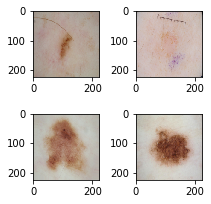

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Using augmentation + ResNet50 preprocessing transformation:
Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
(32, 224, 224, 3) (32, 2)


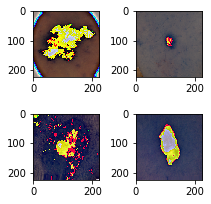

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:
# Creating data with augmentation module on TF
# We'll create three generators using different preprocessing transformations

print("Using ONLY augmentation:")
train_gen, val_gen, test_gen = data_generator()
batch_X, batch_Y = train_gen.next()
print(batch_X.shape, batch_Y.shape)
plot_images(batch_X[:4], 2, 2)
print(batch_Y[:4])

print("Using augmentation + ResNet50 preprocessing transformation:")
train_gen_resnet50, val_gen_resnet50, test_gen_resnet50 = data_generator(
    preprocessing_func=tf.keras.applications.resnet50.preprocess_input
)
batch_X, batch_Y = train_gen_resnet50.next()
print(batch_X.shape, batch_Y.shape)
plot_images(batch_X[:4], 2, 2)
print(batch_Y[:4])

In [9]:
#################################################################
## Atividade 2. Create/Train a simple convolutional neural net as baseline

def create_baseline_model( activation = leaky_relu) -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    # Convolutional layer with 64 filters, 5x5 each
    model.add(
        layers.Conv2D(
            filters=64, 
            kernel_size=(5, 5), 
            padding='valid', 
            activation=activation, 
            input_shape=(224, 224, 3)))
    
    #Max pooling of size 4x4
    model.add(layers.MaxPooling2D(pool_size=(4, 4)))

    # Flattening
    model.add(layers.Flatten())

    # Output layer
    model.add(layers.Dense(2, activation='softmax'))

    return model

In [10]:
# Since we're dealing with a imbalanced dataset, we define the class_weights
# 0 : benign
# 1 : malign

class_weights = {0: 0.615,
                 1: 2.673}

# Creating optimizer
adam = tf.keras.optimizers.Adam(0.001)

# Creating model and checking it
baseline_model = create_baseline_model()
baseline_model.summary()

# Compiling model
baseline_model.compile(loss='categorical_crossentropy', 
                       optimizer=adam, 
                       metrics=['accuracy'])

# Save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_baseline_model.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

# Creating callback
roc = RocCallback(training_data=train_gen,
                  validation_data=val_gen)

with tf.device(device):
  baseline_model.fit(train_gen, 
                     epochs=25, 
                     callbacks=[early, model_checkpoint, roc],
                     verbose=1,
                     validation_data=val_gen,
                     class_weight=class_weights)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 193600)            0         
                                                                 
 dense (Dense)               (None, 2)                 387202    
                                                                 
Total params: 392,066
Trainable params: 392,066
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 624.6043 - accuracy: 0.5235
Epoch 1: val_loss 

In [25]:
baseline_model.load_weights('best_baseline_model.h5')

# predict validation set
y_pred_val = baseline_model.predict(val_gen)

roc_val = roc_auc_score(val_gen.labels, y_pred_val[:,1])
print('AUC validation set:', roc_val)

5/5 [==============================] - 2s 382ms/step
AUC validation set: 0.44833333333333336


Como resultado para o _modelo baseline_ encontramos AUC no conjunto de validação de $0.4483$. O resultado não é muito satisfatório mas a rede encontrada não é muito profunda e não parece extrair as características necessárias do conjunto de dados. Note que o classificador é pior do que um classificador aleatório (e uniforme, com probabilidade $0.5$).

In [12]:
#################################################################
## Atividade 3. Use a pretrained model as feature extractor and train a classifier

# Choosing ResNet50
model = tf.keras.applications.ResNet50(weights='imagenet', 
                                       include_top=False, 
                                       input_shape=(224,224,3))

for layer in model.layers:
    layer.trainable = False

frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D()
])


# Predict using the pretrained model
feats_train = frozen_model.predict(train_gen_resnet50)
feats_val = frozen_model.predict(val_gen_resnet50)

5/5 [==============================] - 2s 440ms/step


In [13]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=rs)

svm = SVC()

param_grid = [    
    {'C' : np.logspace(-3, 2, 6),
     'gamma': np.logspace(-3, 2, 6)}
]

svm_grid = GridSearchCV(estimator = svm, 
                       param_grid = param_grid, 
                       cv = cv, 
                       verbose=10)


svm_grid.fit(feats_train, train_gen_resnet50.labels)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START C=0.001, gamma=0.001.......................................
[CV 1/5; 1/36] END ........C=0.001, gamma=0.001;, score=0.787 total time=   1.1s
[CV 2/5; 1/36] START C=0.001, gamma=0.001.......................................
[CV 2/5; 1/36] END ........C=0.001, gamma=0.001;, score=0.840 total time=   1.2s
[CV 3/5; 1/36] START C=0.001, gamma=0.001.......................................
[CV 3/5; 1/36] END ........C=0.001, gamma=0.001;, score=0.835 total time=   1.2s
[CV 4/5; 1/36] START C=0.001, gamma=0.001.......................................
[CV 4/5; 1/36] END ........C=0.001, gamma=0.001;, score=0.802 total time=   1.2s
[CV 5/5; 1/36] START C=0.001, gamma=0.001.......................................
[CV 5/5; 1/36] END ........C=0.001, gamma=0.001;, score=0.800 total time=   1.1s
[CV 1/5; 2/36] START C=0.001, gamma=0.01........................................
[CV 1/5; 2/36] END .........C=0.001, gamma=0.01

GridSearchCV(cv=KFold(n_splits=5, random_state=321, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}],
             verbose=10)

In [14]:
print(svm_grid.best_estimator_)

SVC(C=0.001, gamma=0.001)


In [15]:
svm = svm_grid.best_estimator_

In [16]:
svm.fit(feats_train, train_gen_resnet50.labels)

# predict validation set
y_pred_val = svm.predict(feats_val)

# Computing AUC of trained classifier
auc_mlp = roc_auc_score(val_gen_resnet50.labels, y_pred_val)

print("AUC SVM:", auc_mlp)

AUC SVM: 0.5


Treinando um classificador **SVM** para o modelo pré-treinado conseguimos um aumento no AUC para $0.5$, mostrando que uma rede pré-treinada conseguiu performar melhor do que o baseline, mas ainda aquém do que espererávamos. Isto pode ser explicado pela arquitetura mais complexa da *ResNet50*, pois utilizamos a rede como extratora de características. No caso do baseline, a rede é muito simples para conseguir identificar qualquer característica ou textura das imagens do dataset.

In [17]:
#################################################################
## Atividade 4. Use a pretrained model 

# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', 
                                       include_top=False, 
                                       input_shape=(224,224,3))
model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

frozen_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
frozen_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

roc = RocCallback(training_data=train_gen_resnet50,
                  validation_data=val_gen_resnet50)

# Save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_frozen_model.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


frozen_model.fit(train_gen_resnet50, epochs=25, 
                 callbacks=[early, model_checkpoint, roc],
                 validation_data=val_gen_resnet50)

Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.7730
Epoch 1: val_loss improved from inf to 0.44590, saving model to best_frozen_model.h5
62/62 [==============================] - 2s 22ms/step
SHAPE (1968, 2)
5/5 [==============================] - 0s 21ms/step
roc-auc_train: 0.7817 - roc-auc_val: 0.7675                                                                                                    
63/63 [==============================] - 37s 536ms/step - loss: 0.6371 - accuracy: 0.7730 - val_loss: 0.4459 - val_accuracy: 0.8200 - train_auc: 0.7817 - val_auc: 0.7675
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8255
Epoch 2: val_loss did not improve from 0.44590
62/62 [==============================] - 1s 21ms/step
SHAPE (1968, 2)
5/5 [==============================] - 0s 21ms/step
roc-auc_train: 0.8165 - roc-auc_val: 0.7644                                                                               

In [19]:
frozen_model.load_weights('best_frozen_model.h5')

# predict validation set
y_pred_val_q4 = frozen_model.predict(val_gen_resnet50)

roc_val_q4 = roc_auc_score(val_gen_resnet50.labels, y_pred_val_q4[:,1])
print('AUC validation set:', roc_val_q4)

5/5 [==============================] - 3s 388ms/step
AUC validation set: 0.5669444444444445


O modelo com as camadas congeladas apresentou um AUC de $0.5669$ no conjunto de validação. Nota-se que tivemos uma melhora quando comparamos ao classificador mais simples acoplado à saída da rede e uma melhora considerável quando comparamos ao baseline. Aqui também valem os argumentos que utilizamos anteriormente, e a complexidade da arquitetura da rede utilizada deve ter contribuído para a identificação das características e, portanto, auxiliado na performance no conjunto de validação.

In [20]:
#################################################################
## Atividade 5. Fine-Tuning model

for layer in model.layers:
    layer.trainable = True

ft_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])    
    
ft_model.summary() #Note o número de paramêtros treináveis

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
# Save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_fine_tuning.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


ft_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

ft_model.fit(train_gen_resnet50, epochs=25, 
             callbacks=[early, model_checkpoint],
             validation_data=val_gen_resnet50)

Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 1.0188 - accuracy: 0.7935
Epoch 1: val_loss improved from inf to 8015463.50000, saving model to best_fine_tuning.h5
63/63 [==============================] - 37s 485ms/step - loss: 1.0188 - accuracy: 0.7935 - val_loss: 8015463.5000 - val_accuracy: 0.8000
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.8090
Epoch 2: val_loss improved from 8015463.50000 to 1216.34058, saving model to best_fine_tuning.h5
63/63 [==============================] - 29s 467ms/step - loss: 0.5243 - accuracy: 0.8090 - val_loss: 1216.3406 - val_accuracy: 0.2067
Epoch 3/25
63/63 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.8035
Epoch 3: val_loss improved from 1216.34058 to 0.85350, saving model to best_fine_tuning.h5
63/63 [==============================] - 30s 469ms/step - loss: 0.5897 - accuracy: 0.8035 - val_loss: 0.8535 - val_accuracy: 0.7600
Epoch 4/25
63/63 [=================

In [31]:
ft_model.load_weights('best_fine_tuning.h5')

# predict validation set
y_pred_val_q5 = ft_model.predict(val_gen_resnet50)

roc_val_q5 = roc_auc_score(val_gen_resnet50.labels, y_pred_val_q5[:,1])
print('AUC validation set:', roc_val_q5)

5/5 [==============================] - 2s 390ms/step
AUC validation set: 0.5622222222222222


O modelo com as camadas descongeladas e usando o *fine_tuning* apresentou AUC de $0.5622$ no conjunto de validação, sendo um resultado próximo do obtido na *Atividade 4*, com o modelo congelado. 

Notamos também que a *val_loss* obteve valores mais baixos para esta configuração de rede e que, nas primeiras épocas houve uma redução grande deste valor, sendo praticamente mantido após a *Epoch 3*

In [32]:
#################################################################
## Atividade 6. Test Set evaluation

ft_model.load_weights('best_fine_tuning.h5')

# predict test set
y_pred_best_model = ft_model.predict(test_gen_resnet50)

roc_test_best_model = roc_auc_score(test_gen_resnet50.labels, y_pred_best_model[:,1])
print('AUC test set:', roc_test_best_model)


19/19 [==============================] - 8s 418ms/step
AUC test set: 0.5140592097113836


Obtivemos um *AUC* de $0.5140$ no conjunto de teste utilizando o resultado obtido pelo **método fine-tuning**.

Observamos que dada a arquitetura de rede escolhida, o classificador obtido é praticamente um classificador aleatório. Isto poderia ser melhorado utilizando outras técnicas de aumentação dos dados ou mesmo outras arquiteturas de rede (aqui utilizamos a *ResNet50*, mas poderíamos escolher outras).


---
---


**Observação**: É importante pontuar que não obtivemos reproducibilidade nos itens deste trabalho. Em uma busca pela documentação do Keras, encontramos o seguinte: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development, em particular o trecho



> *Moreover, when running on a GPU, some operations have non-deterministic outputs, in particular tf.reduce_sum(). This is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed. Due to the limited precision of floats, even adding several numbers together may give slightly different results depending on the order in which you add them. You can try to avoid the non-deterministic operations, but some may be created automatically by TensorFlow to compute the gradients, so it is much simpler to just run the code on the CPU.*



Acreditamos que isto explique os resultados que foram obtidos nos itens acima.